In [1]:
# Generate LDA histograms and reconstructions

In [2]:
!date

Thu Apr 27 09:07:44 PDT 2023


In [3]:
!which python

/home/matheus.viana/anaconda3/envs/lab-variance/bin/python


In [4]:
!pip list | grep cvapipe

cvapipe-analysis           0.1.0                                                         /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis


In [6]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from sklearn.decomposition import PCA
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [18]:
# Controller form cvapipe_analysis
staging = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca9")
config = general.load_config_file(staging)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(147, 1218) /allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca9


In [8]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [12]:
# local_staging_variance_edges is generated by using the output dataframe from the
# mapping process to filter out not matched cells from the full dataset.
dsname = "pca62"
datasets = {
    dsname: {
        "control": "/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca9",
        "perturbed": "/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca62"
    }}

In [10]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)
df_map = smapper.result
df_map.head()

	pca62 loaded. (138, 1218)


NUC_MEM_PC1  Dist  SelfDist NNCellId  Match  \
dataset structure_name CellId                                                  
base    ADH            067j0pix     0.014331   NaN       NaN       -1  False   
                       32asvegl     0.130543   NaN       NaN       -1  False   
                       3gp9pks0     0.992096   NaN       NaN       -1  False   
                       466dclnw     0.700845   NaN       NaN       -1  False   
                       4731xeaf     0.327921   NaN       NaN       -1  False   

                                 pca62  
dataset structure_name CellId           
base    ADH            067j0pix   True  
                       32asvegl  False  
                       3gp9pks0  False  
                       466dclnw  False  
                       4731xeaf  False

### Loading and voxelizing matched shape

In [13]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{inner_alias}_matched.vtk"
inner_mesh = device.read_vtk_polydata(fname)
outer_alias = control.get_outer_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{outer_alias}_matched.vtk"
outer_mesh = device.read_vtk_polydata(fname)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [14]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

### Control and Device for each shape matched dataset (control and perturbed)

In [21]:
importlib.reload(io)
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/notebooks/FigureEdges/../tools/common.py'>

In [22]:
dsmanagers = common.setup_cvapipe_for_matched_dataset(datasets[dsname])

### Load representations and compute PCA

In [25]:
gene = "SARC"
namemap = {"control": "base", "perturbed": dsname}

In [26]:
df_gene = df_map.loc[(dsname,gene)]

CellIds_pt = df_gene.index.values
CellIds_ct = df_gene.NNCellId.unique()

rloader_ct = common.RepsSharedMemoryLoader(dsmanagers["control"]["control"])
rloader_pt = common.RepsSharedMemoryLoader(dsmanagers["perturbed"]["control"])
reps_ct = rloader_ct.load(CellIds_ct).astype(np.uint8)
reps_pt = rloader_pt.load(CellIds_pt).astype(np.uint8)

  0%|          | 0/20 [00:00<?, ?it/s]

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The de

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


  0%|          | 0/46 [00:00<?, ?it/s]

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The de

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The de

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The de

In [14]:
# df_gene = df_map.loc[(dsname,gene)]

# CellIds_pt = df_gene.index.values[:10]
# CellIds_ct = df_gene.NNCellId.unique()[:10]

# CellIds_ct, reps_ct = common.get_all_parameterized_intensity_of_seg_channel(CellIds_ct, dsmanagers["control"]["device"])
# CellIds_pt, reps_pt = common.get_all_parameterized_intensity_of_seg_channel(CellIds_pt, dsmanagers["perturbed"]["device"])

# print(reps_ct.max(), reps_ct.sum(), reps_pt.sum())

# # rloader_ct = common.RepsSharedMemoryLoader(dsmanagers["control"]["control"])
# # rloader_pt = common.RepsSharedMemoryLoader(dsmanagers["perturbed"]["control"])
# # reps_ct = rloader_ct.load(CellIds_ct)
# # reps_pt = rloader_pt.load(CellIds_pt)

In [27]:
reps = np.concatenate([reps_ct, reps_pt], axis=0)
vsize = int(sys.getsizeof(reps)) / float(1 << 20)
print(f"Data shape: {reps.shape} ({reps.dtype}, {vsize:.1f}Mb)")

Data shape: (66, 532610) (uint8, 33.5Mb)


In [28]:
npcs = np.min([32, reps.shape[0]-1])
pca = PCA(npcs, svd_solver="full")
pca = pca.fit(reps)
axes = pca.transform(reps)
axes = pd.DataFrame(axes, columns=[f"PC{i}" for i in range(1, 1+npcs)])

In [29]:
groups = np.array([0]*len(CellIds_ct) + [1]*len(CellIds_pt))
stds = axes.std(axis=0)
axes /= stds
axes, pca = common.sort_pcs(axes, groups, pca)
axes["Dataset"] = groups
axes["CellId"] = CellIds_ct.tolist() + CellIds_pt.tolist()
axes = axes.set_index(["Dataset", "CellId"])
axes.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
Dataset CellId                                                                 
0       n5p262x9 -0.457712 -1.543619 -0.343391  0.950466 -2.538534  0.188054   
        esd0qih8  0.508153  0.242539  0.352000  0.202276 -0.196177 -0.099948   
        iid2uyz5  0.523737 -1.003162 -0.855465 -0.616497 -0.746364 -0.255584   
        yjuw9t9d -0.485820  1.223378 -1.055941  0.823870  0.143392  0.884279   
        f56xrfp6  0.506123  0.242521  0.345611  0.139688 -0.212323 -0.094421   

                       PC7       PC8       PC9      PC10  ...      PC23  \
Dataset CellId                                            ...             
0       n5p262x9 -0.135205 -1.695079 -0.549850 -4.486278  ...  0.444408   
        esd0qih8 -0.059625  0.054081 -0.075735  0.115931  ...  0.075002   
        iid2uyz5 -0.561897 -1.447925 -0.418212  0.466586  ...  1.870595   
        yjuw9t9d  1.353711 -0.655806  2.665769 -0.330736  ... -0.683367   
        f56xrfp6  0.015623  0.060021 -0.076232  0.165395  ...  0.097723   

                      PC24      PC25      PC26      PC27      PC28      PC29  \
Dataset CellId                                                                 
0       n5p262x9 -0.118144  0.658282 -0.569159 -0.223836 -0.046596  0.168040   
        esd0qih8  0.017799 -0.252705  0.102335  0.010207  0.147759  0.200752   
        iid2uyz5 -2.636516 -2.252408 -0.030804 -0.028671  0.274490 -0.263923   
        yjuw9t9d -0.827001  1.149963 -2.064859 -0.085778 -0.236089 -0.387398   
        f56xrfp6  0.090161 -0.257824  0.087240 -0.133812  0.164825  0.199655   

                      PC30      PC31      PC32  
Dataset CellId                                  
0       n5p262x9  0.016829  0.170710  0.441670  
        esd0qih8 -0.280328 -0.329354  0.106681  
        iid2uyz5  0.120489 -0.070885  0.085903  
        yjuw9t9d  0.187024  0.037559  0.224568  
        f56xrfp6 -0.149999 -0.165849  0.070061  

[5 rows x 32 columns]

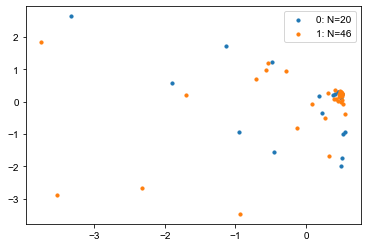

In [31]:
fig, ax = plt.subplots(1,1)
for ds, df_ds in axes.groupby("Dataset"):
    ax.scatter(df_ds.PC1, df_ds.PC2, s=10, label=f"{ds}: N={len(df_ds)}")
plt.legend()
plt.show()

### Compute LDA

In [32]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/notebooks/FigureEdges/../tools/common.py'>

In [33]:
lda = common.SimpleBinaryLDA()
lda = lda.sfit(axes.values, groups)
lda_values = lda.transform(axes.values).flatten()
axes["LDA"] = lda_values

0 -1.1606076
1 0.504612


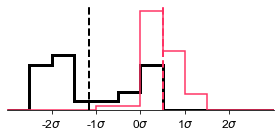

In [34]:
xmin, xmax = -3, 3
edges = np.linspace(xmin, xmax, 1+int((xmax-xmin)/0.5))
fig, ax = plt.subplots(1,1, figsize=(4.0, 2))
for color, (g, df_group) in zip(["black","#FF3264"], axes.groupby("Dataset")):
    lw = 3 if g == 0 else 1.5
    ax.hist(df_group.LDA, bins=edges, histtype="step", color=color, density=True, lw=lw)
    ax.axvline(x=df_group.LDA.mean(), color=color, lw=2, linestyle="--", zorder=1e10)
    print(g, df_group.LDA.mean())
ax.set_xlim(xmin, xmax)
for pos in ["top", "right", "left"]:
    ax.spines[pos].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sigmas = np.linspace(-2, 2, 5)
ax.set_xticks(sigmas, [f"{int(s)}$\sigma$" for s in sigmas])
ax.tick_params(axis="x", which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f"FigureEdges3_{gene}_lda_hist.pdf")
plt.show()

In [43]:
mps = [-2,-1.5,-1,0.5,0,0.5,1,1.5,2]
pcs_back = lda.walk(mps)#, limit_to_range=lda_values, return_map_points=True)
pcs_back *= stds.values
pcs_back = pd.DataFrame(pcs_back, columns=[f"PC{i}" for i in range(1,1+npcs)])
reps_back = pca.inverse_transform(pcs_back).reshape(len(mps), 65, -1)

In [44]:
instances = []
for rep in tqdm(reps_back):
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=rep
    )
#     morphed -= morphed.min() #shift to make min val = 0
    instances.append(np.stack([domain_nuc, domain_mem, morphed], axis=0))

  0%|          | 0/9 [00:00<?, ?it/s]

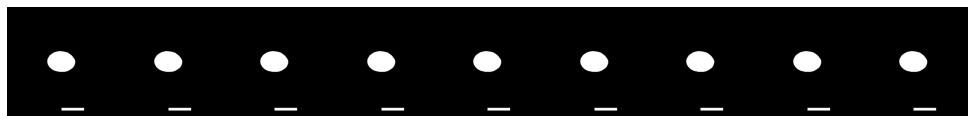

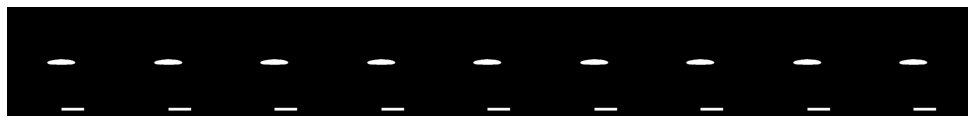

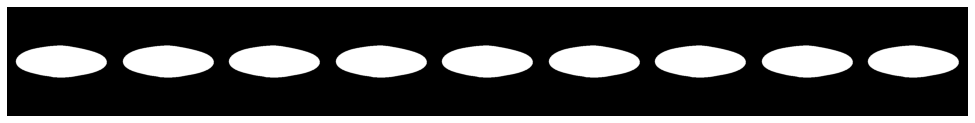

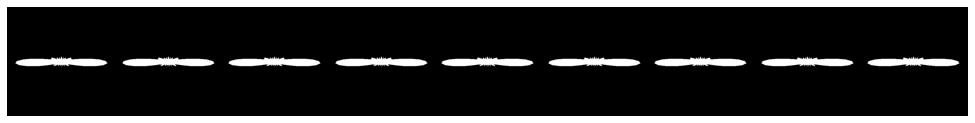

In [45]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.3}, "sharex": True, "sharey": True}
for alias in ["nuc", "mem"]:
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,len(mps), figsize=(2*len(mps), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=400)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.18, "length":15})
        plt.savefig(f"FigureEdges3_{gene}_lda_{alias}_{orient}.png", dpi=150)
        plt.show()

In [46]:
# Percentil relative to center
contrast = common.Projector.get_shared_morphed_max_based_on_pct_for_zy_views(
    instances = instances,
    pct = 90,
    mode = mode,
    func = np.mean
)

In [47]:
orients = ["z", "y"]
vmin, vmax = 0, np.nanmax([contrast[ax][1] for ax in orients])
print(gene, vmin, vmax)

SARC 0 0.22920627726448906


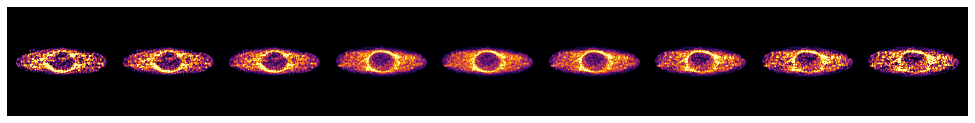

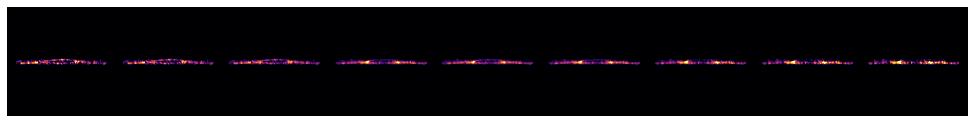

In [48]:
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.3}, "sharex": True, "sharey": True}
for orient in ["z", "y"]:
    fig, axs = plt.subplots(1,len(mps), figsize=(2*len(mps), 2), **args)
    for ax, instance in zip(axs, instances):
        ax.axis("off")
        proj = common.Projector(instance, box_size=400)
        proj.set_gfp_colormap("inferno")
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_projection_mode(ax=orient, mode=mode)
        view = proj.project_on(alias="gfp", ax=ax)
    plt.savefig(f"FigureEdges3_{gene}_lda_gfp_{orient}.png", dpi=150)
    plt.show()

# Paused here

### Reconstruct chosen instances along LDA

In [41]:
dfs = {}
for condition, manager in dsmanagers.items():
    dfs[condition] = manager["device"].load_step_manifest("preprocessing")
    print(condition, dfs[condition].shape)

control (147, 1218)
perturbed (138, 1218)


In [28]:
# Ids from the gene being analyzed
representative_ids = {
    "TOMM20": [350008, 324609, 321239, 973641, 267287, 929060],
    "ACTN": [572411, 541232, 577227,560334, 635240, 556067]
}

In [29]:
instances = []
for CellId in tqdm(representative_ids[gene]):
    _, ds = axes.index.get_loc_level(CellId, "CellId")
    # Control=0, Perturbed=1
    condition = "control" if ds[0]==0 else "perturbed"
    control_cond = dsmanagers[condition]["control"]
    print(CellId, condition, f"{axes.at[(ds[0],CellId),'LDA']:.2f}")
    row = dfs[condition].loc[CellId].copy()
    if condition == "control":
        row.crop_seg = row.crop_seg.replace("projects/cvapipe_analysis/local_staging_variance_edges", "datasets/hpisc_single_cell/variance/local_staging_variance")
        row.crop_seg = row.crop_seg.split("ome")[0]+"ome.tif"
    producer = io.DataProducer(control_cond)
    producer.set_row(row)
    producer.load_single_cell_data()
    producer.align_data(force_alignment=True)
    instances.append(producer.data_aligned[[3, 5, 7]])

  0%|          | 0/6 [00:00<?, ?it/s]

350008 control -1.85
324609 control -0.73
321239 control -0.03
973641 perturbed 0.26
267287 perturbed 0.94
929060 perturbed 1.82


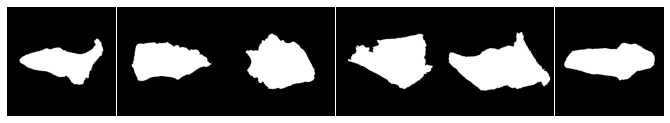

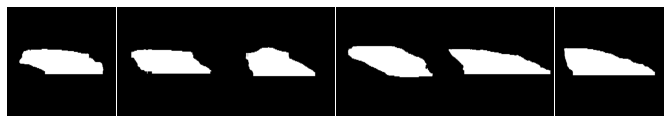

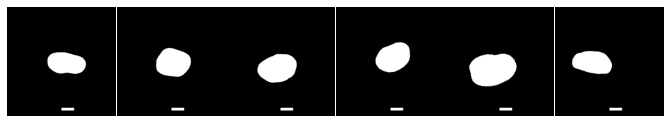

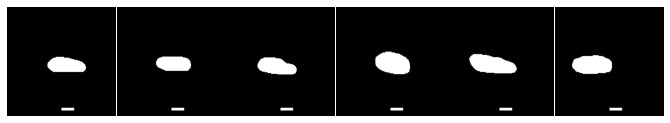

In [30]:
mode = {
    "nuc": "max",
    "mem": "max",
    "gfp": "mean"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.1}, "sharex": True, "sharey": True}
for alias in ["mem", "nuc"]:
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=396)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureEdges3_{gene}_inst_{alias}_{orient}.png", dpi=150)
        plt.show()

In [31]:
vmin, vmax = control.get_optimal_seg_contrast(gene)

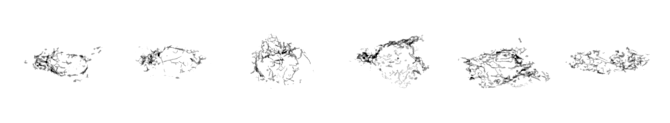

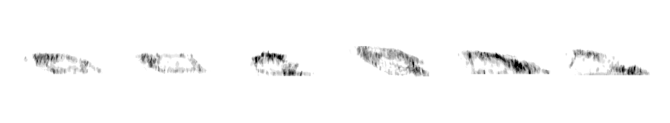

In [32]:
for orient in ["z", "y"]:
    fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
    for ax, instance in zip(axs, instances):
        ax.axis("off")
        proj = common.Projector(instance, box_size=396)
        proj.set_projection_mode(ax=orient, mode=mode)
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_gfp_colormap("binary")
        view = proj.project_on(alias="gfp", ax=ax)
        plt.savefig(f"FigureEdges3_{gene}_inst_gfp_{orient}.png", dpi=150)
    plt.show()

### Reconstruct morphed version of chosen instances along LDA

In [33]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{inner_alias}_matched.vtk"
inner_mesh = device.read_vtk_polydata(fname)
outer_alias = control.get_outer_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{outer_alias}_matched.vtk"
outer_mesh = device.read_vtk_polydata(fname)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [34]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

In [35]:
instances = []
for CellId in tqdm(representative_ids[gene]):
    _, ds = axes.index.get_loc_level(CellId, "CellId")
    condition = "control" if ds[0]==0 else "perturbed"
    device_cond = dsmanagers[condition]["device"]
    rep = device_cond.read_parameterized_intensity(CellId)
    
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=rep
    )
    instances.append(np.stack([domain_nuc, domain_mem, morphed], axis=0))

  0%|          | 0/6 [00:00<?, ?it/s]

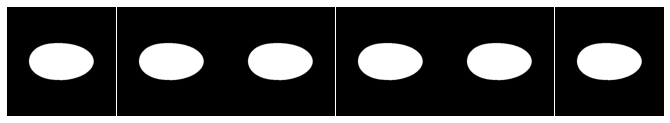

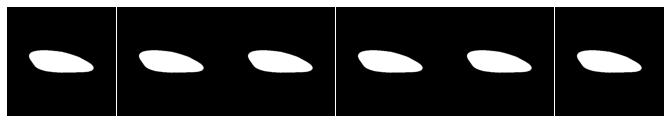

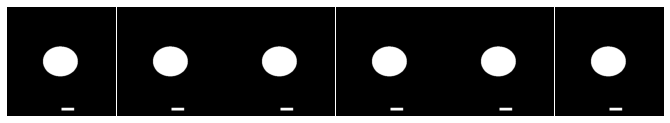

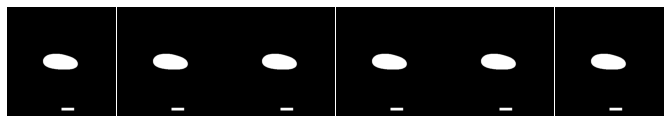

In [36]:
for alias in ["mem", "nuc"]:
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=396)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureEdges3_{gene}_morphinst_{alias}_{orient}.png", dpi=150)
        plt.show()

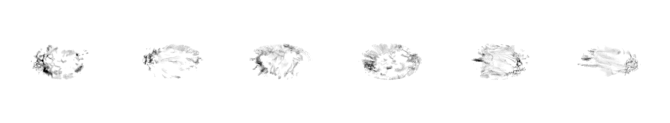

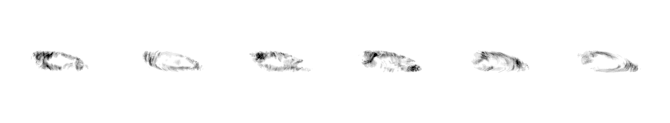

In [37]:
for orient in ["z", "y"]:
    fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
    for ax, instance in zip(axs, instances):
        ax.axis("off")
        proj = common.Projector(instance, box_size=396)
        proj.set_projection_mode(ax=orient, mode=mode)
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_gfp_colormap("binary")
        view = proj.project_on(alias="gfp", ax=ax)
        plt.savefig(f"FigureEdges3_{gene}_morphinst_gfp_{orient}.png", dpi=150)
    plt.show()

In [38]:
common.now("complete")

complete 2022-06-27 13:15:31
